## R-alpha

In [1]:
!pip install smartapi-python
!pip install websocket-client
!pip install logzero
!pip install pyotp
!pip install requests
!pip install numpy
!pip install pandas
!pip install yfinance

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 71.6 MB/s eta 0:00:00:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 23.5 MB/s eta 0:00

In [2]:
# package import statement
from SmartApi import SmartConnect #or from SmartApi.smartConnect import SmartConnect
import pyotp
from logzero import logger
from connect_api import connect_api, create_api_session
from data import get_data_stream, token_lookup, get_instrument_list, hist_data, hist_data_from_now
from strategy import expected_buy_price, expected_sell_price, trend_detection, exit_long, exit_short
from order import place_limit_order, place_market_order
from momentum import get_top_nse_stocks_by_volume, momentum_strategy
import json
import threading
import time   

In [9]:
with open('credentials.json', 'r') as file:
    credentials = json.load(file)

api_key = credentials['api_key']
token_id = credentials['token_id']
username = credentials['username']
pwd = credentials['pwd']

In [10]:
smartApi = connect_api(api_key)
data = create_api_session(token_id, username, pwd, smartApi)

[I 240522 10:07:54 smartConnect:121] in pool


### Get Ticker Data

In [11]:
instrument_list = get_instrument_list()

ticker_list = ["ITC"]
token_list_0 = []

for ticker in ticker_list:
    token = token_lookup(ticker, instrument_list, exchange="NSE")
    token_list_0.append(token)

token_list = [
        {
            "exchangeType": 1,
            "tokens": token_list_0
        }
    ]


print(token_list)

[{'exchangeType': 1, 'tokens': ['1660']}]


## Create Live Data Stream

In [ ]:
correlation_id = "stream_2" #any string value which will help identify the specific streaming in case of concurrent streaming
action = 1 #1 subscribe, 0 unsubscribe
mode = 1 #1 for LTP, 2 for Quote and 3 for SnapQuote
    
sws = get_data_stream(token_id, api_key, username, smartApi.getfeedToken(), token_list, correlation_id, action, mode)

## Momentum Strategy

In [ ]:
top_10_stocks = get_top_nse_stocks_by_volume(instrument_list[:100])

In [ ]:
top_10_stocks

In [75]:
import pandas as pd

ticker_ltp = {}
position = 0
momentum_short_window = 3
momentum_long_window = 12
trades = {}
capital = 1500

def momentum_strategy(tick):

    global position
    global trades
    global capital
    global ticker_ltp
    ### add ltp and return to dictionary
    token = tick['token']
    ltp = tick['last_traded_price']/100

    print(ltp)

    momentum_signal = 0

    if token in ticker_ltp:
        ticker_ltp[token]['ltp'].append(ltp)
        momentum_short = pd.Series(ticker_ltp[token]['ltp']).rolling(window=momentum_short_window).mean().iloc[-1]

        ticker_ltp[token]['momentum_short'].append(momentum_short)
        momentum_long = pd.Series(ticker_ltp[token]['ltp']).rolling(window=momentum_long_window).mean().iloc[-1]
        ticker_ltp[token]['momentum_long'].append(momentum_long)
    else:
        ticker_ltp[token] = {
            'ltp': [ltp],
            'momentum_short':[None],
            'momentum_long': [None]
        }


    # Check momentum signal
    if (ticker_ltp[token]['momentum_short'][-1] is not None) and (ticker_ltp[token]['momentum_long'][-1] is not None):
        if ticker_ltp[token]['momentum_short'][-1] > ticker_ltp[token]['momentum_long'][-1]:
            momentum_signal = 1
        elif ticker_ltp[token]['momentum_short'][-1] < ticker_ltp[token]['momentum_long'][-1]:
            momentum_signal = -1

    #create trade

    if momentum_signal == 1 and position == 0:
        quantity = capital // ltp
        price = ltp
        position = 1
        capital = 0

        if token in trades:
            trades[token]['buy_prices'].append(price)
            trades[token]['quantity'].append(quantity)
            # trades[token]['sell_price'].append(None)
        
        else:
            trades[token] = {
            'buy_prices': [price],
            'quantity': [quantity],
            'sell_price': []
            }

        place_limit_order(instrument_list,"ITC",'BUY',price,quantity,smartApi, exchange="NSE")

    elif momentum_signal == -1 and position == 1:
        quantity = trades[token]['quantity'][-1]
        price = ltp
        position = 0

        capital = quantity*price
        if token in trades:
            trades[token]['sell_price'].append(price)
        
        else:
            trades[token] = {
            'sell_price':price
            }

        place_limit_order(instrument_list,"ITC",'SELL',price,quantity,smartApi, exchange="NSE")

def on_data(ws, message):
    momentum_strategy(message)

sws.on_data = on_data

In [76]:
sws.connect()

[I 240507 08:42:44 data:94] on open


440.5
440.5
440.5
440.5
440.5
440.5
440.55
440.55
440.6
440.5
440.45
440.55
440.6
440.45
440.6
440.55
440.55
440.5
440.45
440.55
440.55
440.55
440.6
440.6
440.6
440.55
440.6
440.6
440.6
440.6
440.6
440.6
440.55
440.6
440.6
440.6
440.6
440.6
440.6
440.5
440.5
440.5
440.5
440.6
440.6
440.6


[E 240507 08:43:19 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.6, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '388e169b-ca97-4295-a3ba-6a4cdd11a8be'}}
[E 240507 08:43:19 smartConnect:336] API request f

440.6
440.6
440.6
440.6
440.6
440.45


[E 240507 08:43:23 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.45, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'cc668f28-d8b7-4ec1-a2a1-66abdd665ea0'}}
[E 240507 08:43:23 smartConnect:336] API request

440.5
440.5
440.5
440.5
440.45
440.45
440.45
440.5
440.5
440.5


[E 240507 08:43:29 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.5, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'd8ae45f6-8f1b-4796-9e65-b1ea363d7ee6'}}
[E 240507 08:43:29 smartConnect:336] API request f

440.5
440.5
440.5
440.5
440.5
440.5
440.5
440.5
440.5
440.5
440.5
440.5
440.5
440.5
440.5
440.5
440.5
440.5
440.5
440.5
440.45


[E 240507 08:43:40 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.45, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'd31fec4a-8b2a-43a2-a6e2-84bce1e5eaf7'}}
[E 240507 08:43:40 smartConnect:336] API request

440.45
440.4
440.5
440.45
440.45
440.5
440.5


[E 240507 08:43:46 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.5, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'c5cfed60-56e5-4c71-a655-467fe519c483'}}
[E 240507 08:43:46 smartConnect:336] API request f

440.45
440.5
440.5
440.5
440.45
440.45


[E 240507 08:43:51 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.45, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '0156edbd-16f2-4a56-be1b-915ec8a97167'}}
[E 240507 08:43:51 smartConnect:336] API request

440.5
440.5


[E 240507 08:43:52 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.5, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'b416a5f5-e8f6-44ee-8ae7-c8c112dc1f50'}}
[E 240507 08:43:52 smartConnect:336] API request f

440.5
440.5
440.45
440.5
440.55
440.55
440.5
440.5
440.6
440.6
440.6
440.6
440.55
440.6
440.6
440.55
440.6
440.6
440.55
440.55


[E 240507 08:44:09 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.55, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '9af269be-b8a2-40f1-835c-4eaf1565e59f'}}
[E 240507 08:44:09 smartConnect:336] API request

440.6
440.6
440.6


[E 240507 08:44:12 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.6, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '93e515e0-a00f-442a-99cf-ae8573df8d96'}}
[E 240507 08:44:12 smartConnect:336] API request f

440.65
440.7
440.7
440.7
440.7
440.55
440.55


[E 240507 08:44:17 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.55, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'e3198657-cb05-438c-bc8f-7510a2c82b90'}}
[E 240507 08:44:17 smartConnect:336] API request

440.7
440.6
440.7


[E 240507 08:44:20 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.7, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'f98bf1d6-d7c4-4683-acf2-4c971addeb8c'}}
[E 240507 08:44:20 smartConnect:336] API request f

440.7
440.7
440.75
440.55
440.7
440.55


[E 240507 08:44:25 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.55, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '0eba7dea-a11b-4b24-9ead-284e059b5cf9'}}
[E 240507 08:44:25 smartConnect:336] API request

440.35
440.5
440.5
440.5
440.6
440.6
440.65


[E 240507 08:44:31 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.65, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '9f08071e-bbbc-49f1-b3c1-62d127e7f1a5'}}
[E 240507 08:44:31 smartConnect:336] API request 

440.65
440.7
440.7
440.7
440.65
440.5
440.6


[E 240507 08:44:36 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.6, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '9511d2a9-4f6b-4a2a-b5eb-cca35023986d'}}
[E 240507 08:44:36 smartConnect:336] API request 

440.65
440.55
440.65
440.7
440.7


[E 240507 08:44:41 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.7, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '47530e70-c09a-4358-ad62-ad7a77a9d63e'}}
[E 240507 08:44:41 smartConnect:336] API request f

440.7
440.7
440.7
440.65
440.7
440.75
440.7
440.75
440.75
440.8
440.8
440.8
440.75
440.9
440.9
440.9
440.9
440.9
440.8
440.8
440.85


[E 240507 08:44:58 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.85, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '1a7276be-2f5a-49e8-b410-712cb5458ffa'}}
[E 240507 08:44:58 smartConnect:336] API request

440.7
440.8
440.8
440.8
440.8
440.8
440.8
440.7
440.8
440.8
440.8


[E 240507 08:45:08 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.8, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'c0354f77-67a0-4fca-8e5e-e3bb421d3e41'}}
[E 240507 08:45:08 smartConnect:336] API request f

440.8
440.8
440.8
440.75


[E 240507 08:45:11 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.75, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '8ce05bab-a79f-49f8-a340-d5c8a084302b'}}
[E 240507 08:45:11 smartConnect:336] API request

440.8
440.8
440.8


[E 240507 08:45:13 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.8, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '3583161c-3392-4377-9798-b1e00263826c'}}
[E 240507 08:45:13 smartConnect:336] API request f

440.8
440.8
440.8
440.8
440.8
440.8
440.8
440.7


[E 240507 08:45:20 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.7, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '5fe9edb8-156f-48e5-9a5d-6cd39eca3772'}}
[E 240507 08:45:20 smartConnect:336] API request 

440.7
440.8
440.8
440.8


[E 240507 08:45:22 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.8, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '287631ca-3015-43cb-95ca-3197e1ff134c'}}
[E 240507 08:45:22 smartConnect:336] API request f

440.8
440.8
440.7


[E 240507 08:45:24 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.7, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '0fd5366f-a470-473e-8a8a-a717563cdca4'}}
[E 240507 08:45:24 smartConnect:336] API request 

440.8
440.8
440.8


[E 240507 08:45:25 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.8, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '20ab1119-d2e9-4da1-8336-066050e86a1e'}}
[E 240507 08:45:25 smartConnect:336] API request f

440.8
440.8
440.8
440.8
440.8
440.8
440.8
440.55


[E 240507 08:45:29 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.55, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '1abfc1bd-eb55-4628-8111-d28c052a976e'}}
[E 240507 08:45:29 smartConnect:336] API request

440.55
440.65
440.65
440.8
440.8


[E 240507 08:45:31 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.8, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '48b5fb37-fc36-4b3d-b083-19fc9d7c1017'}}
[E 240507 08:45:31 smartConnect:336] API request f

440.8
440.8
440.55
440.55


[E 240507 08:45:33 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.55, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '5e931638-dc3d-4246-b082-d1fb3b148072'}}
[E 240507 08:45:33 smartConnect:336] API request

440.75
440.75
440.8


[E 240507 08:45:35 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.8, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '67e7d5fe-f0ee-4584-837c-08c77c1e8d33'}}
[E 240507 08:45:35 smartConnect:336] API request f

440.8
440.8
440.8
440.85
440.7
440.75
440.85
440.85
440.85
440.85
440.85
440.6


[E 240507 08:45:41 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.6, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '0d0ebe26-eaee-419c-a8b9-6e5092663a01'}}
[E 240507 08:45:41 smartConnect:336] API request 

440.6
440.6
440.6
440.6
440.6
440.6
440.6
440.6
440.6
440.6
440.5
440.65
440.65
440.75


[E 240507 08:45:48 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.75, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '46946b1c-3a9f-4db4-8e2a-5842860464ad'}}
[E 240507 08:45:48 smartConnect:336] API request 

440.7
440.75
440.75
440.7
440.7
440.8
440.8
440.8
440.75
440.75
440.75
440.75
440.8
440.8
440.8
440.75
440.75


[E 240507 08:45:57 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.75, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '92125ee2-861f-4861-9043-d345d5d40698'}}
[E 240507 08:45:57 smartConnect:336] API request

440.75
440.8
440.8


[E 240507 08:45:58 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.8, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'b71e2b6a-2aa3-44d6-9aef-9f1712b74d56'}}
[E 240507 08:45:58 smartConnect:336] API request f

440.75
440.75


[E 240507 08:45:59 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.75, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'cc6de016-d88a-4abb-81ca-efa0d6e708b0'}}
[E 240507 08:45:59 smartConnect:336] API request

440.75
440.75
440.75
440.75
440.75
440.8


[E 240507 08:46:02 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.8, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '06dd8718-2d7e-4146-94c8-a851f8ceac58'}}
[E 240507 08:46:02 smartConnect:336] API request f

440.75
440.65


[E 240507 08:46:03 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.65, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '88ac3a8e-81d8-4559-8eaf-c6bf69b1f520'}}
[E 240507 08:46:03 smartConnect:336] API request

440.8
440.8
440.8


[E 240507 08:46:05 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.8, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '52e335d9-a159-487a-8603-c59d5e1bc801'}}
[E 240507 08:46:05 smartConnect:336] API request f

440.65
440.65


[E 240507 08:46:06 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.65, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '694ac9f5-f823-4dba-9412-01dc379310f6'}}
[E 240507 08:46:06 smartConnect:336] API request

440.8
440.8
440.8


[E 240507 08:46:07 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.8, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'fa47ff63-3cdb-418d-b3c1-70fc74dd22ac'}}
[E 240507 08:46:07 smartConnect:336] API request f

440.8
440.8
440.8
440.8
440.8
440.8
440.75
440.75


[E 240507 08:46:11 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.75, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'eede7bdc-31bc-40a4-b927-3a58f72b7c46'}}
[E 240507 08:46:11 smartConnect:336] API request

440.6
440.85
440.85
440.85


[E 240507 08:46:13 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.85, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '08d39aa8-046f-4d7e-91e1-78b22f7912d2'}}
[E 240507 08:46:13 smartConnect:336] API request 

440.6


[E 240507 08:46:14 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.6, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '68cc9d63-0a82-4c3a-b1af-2cb3063dc922'}}
[E 240507 08:46:14 smartConnect:336] API request 

440.6
440.6
440.6
440.6
440.6
440.6
440.6
440.5
440.5
440.5
440.5
440.6
440.6
440.6


[E 240507 08:46:19 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.6, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '80dd9b4d-ed5f-40eb-bc67-5d03266e7d12'}}
[E 240507 08:46:19 smartConnect:336] API request f

440.6
440.6
440.6
440.55
440.6
440.6
440.6
440.6
440.6
440.5


[E 240507 08:46:23 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.5, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '9f5cc6de-1745-4ed7-8083-a09f6f143906'}}
[E 240507 08:46:23 smartConnect:336] API request 

440.6
440.6
440.6


[E 240507 08:46:25 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.6, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'c7b87afb-c4d5-4ab6-9c34-03dfac325dfa'}}
[E 240507 08:46:25 smartConnect:336] API request f

440.55
440.55


[E 240507 08:46:26 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.55, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'dd25fd13-0097-48f5-a9d1-3e85104764a1'}}
[E 240507 08:46:26 smartConnect:336] API request

440.6
440.6
440.6


[E 240507 08:46:28 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.6, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '97f822b7-7e78-41ba-a74d-832f26af7fcb'}}
[E 240507 08:46:28 smartConnect:336] API request f

440.6
440.6
440.6
440.6
440.6
440.6
440.6
440.6
440.6
440.55


[E 240507 08:46:33 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.55, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '03215ff8-df1d-4a23-9e00-5d1813800681'}}
[E 240507 08:46:33 smartConnect:336] API request

440.55
440.6
440.6
440.55
440.55
440.6
440.55
440.55
440.6
440.6


[E 240507 08:46:38 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.6, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '18bd1e31-2a67-41b7-a5ab-16890f249897'}}
[E 240507 08:46:38 smartConnect:336] API request f

440.6
440.55
440.6
440.6
440.6
440.6
440.6
440.55


[E 240507 08:46:44 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.55, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '259804c2-1111-4b23-a65e-c7bae1d92cef'}}
[E 240507 08:46:44 smartConnect:336] API request

440.6
440.6
440.6


[E 240507 08:46:47 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.6, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'f5bd0a18-9d96-4f7e-a1d4-80bed9ab4522'}}
[E 240507 08:46:47 smartConnect:336] API request f

440.6
440.6
440.6
440.55


[E 240507 08:46:50 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.55, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '28e1ac62-70a8-4d6e-9766-3a7642a366ea'}}
[E 240507 08:46:50 smartConnect:336] API request

440.55
440.6
440.6
440.5
440.6
440.6
440.6


[E 240507 08:46:56 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.6, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '0192dc41-70e9-4840-922d-7245710d795b'}}
[E 240507 08:46:56 smartConnect:336] API request f

440.6
440.6
440.6
440.55
440.6
440.6


[E 240507 08:47:01 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.6, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '167506a1-4f37-4400-b47f-326fd987b646'}}
[E 240507 08:47:01 smartConnect:336] API request 

440.55
440.6
440.55
440.6
440.6
440.6


[E 240507 08:47:06 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.6, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '0e62e0e1-f843-41c1-a3f5-22cacfbfe7c9'}}
[E 240507 08:47:06 smartConnect:336] API request f

440.55
440.55


[E 240507 08:47:07 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.55, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'f1d94edd-26fb-48e9-9711-b0c8181487b8'}}
[E 240507 08:47:07 smartConnect:336] API request

440.7


[E 240507 08:47:08 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.7, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '838f6dc5-ab98-478e-919c-b1dc84a60f38'}}
[E 240507 08:47:08 smartConnect:336] API request f

440.7
440.5
440.7
440.65
440.65
440.65
440.7
440.65
440.7
440.7
440.7
440.65
440.7
440.7
440.7
440.7
440.7
440.5


[E 240507 08:47:23 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.5, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '91f57047-8a92-4620-8486-8a5452e8b55f'}}
[E 240507 08:47:23 smartConnect:336] API request 

440.7
440.5
440.5
440.4
440.4
440.45
440.45
440.35
440.45
440.45
440.45
440.45
440.45


[E 240507 08:47:34 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.45, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '37374091-59da-4397-bf7e-a09b9dadc2e9'}}
[E 240507 08:47:34 smartConnect:336] API request 

440.45
440.45
440.45
440.4


[E 240507 08:47:38 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.4, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'fe092915-5609-47b6-8ae6-11dd127107cf'}}
[E 240507 08:47:38 smartConnect:336] API request 

440.4
440.4
440.45
440.5


[E 240507 08:47:41 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.5, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'b26b8aa1-2aff-4504-a5e9-8fcbc043df98'}}
[E 240507 08:47:41 smartConnect:336] API request f

440.4
440.4
440.4


[E 240507 08:47:43 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.4, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '6e549561-a112-412f-83e0-b89bd4a0a2fd'}}
[E 240507 08:47:43 smartConnect:336] API request 

440.4
440.4
440.4
440.4
440.45
440.45


[E 240507 08:47:48 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.45, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '9a506796-6fa4-4af9-866c-d500090c7c60'}}
[E 240507 08:47:48 smartConnect:336] API request 

440.5
440.35
440.5
440.5
440.4
440.4
440.45


[E 240507 08:47:54 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.45, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'd5b4d802-60fb-461b-bdf2-b71306cbaee0'}}
[E 240507 08:47:54 smartConnect:336] API request

440.5


[E 240507 08:47:55 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.5, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '01405100-f5a4-466c-8ab8-7989b0d73659'}}
[E 240507 08:47:55 smartConnect:336] API request f

440.4
440.45
440.45


[E 240507 08:47:58 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.45, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '55d65add-e466-456d-bf47-e0eec65f60da'}}
[E 240507 08:47:58 smartConnect:336] API request

440.45


[E 240507 08:47:59 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.45, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '22cce615-7497-448d-8f6b-0437c8051e9b'}}
[E 240507 08:47:59 smartConnect:336] API request 

440.45
440.35


[E 240507 08:48:01 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.35, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'e96a88fe-d177-4014-bbfb-37ad228bbf00'}}
[E 240507 08:48:01 smartConnect:336] API request

440.35
440.3
440.3
440.35
440.35
440.35
440.35
440.35
440.35
440.35
440.3
440.35
440.35
440.35


[E 240507 08:48:13 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.35, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'c57e7c79-d3e2-4fd1-9bca-a35c0bd49656'}}
[E 240507 08:48:13 smartConnect:336] API request 

440.3


[E 240507 08:48:14 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.3, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '10b6c6f6-a964-428b-bea4-a99613c2fbb6'}}
[E 240507 08:48:14 smartConnect:336] API request 

440.3
440.3
440.3
440.25
440.25
440.3
440.3
440.25
440.3
440.3
440.3


[E 240507 08:48:23 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.3, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'b3c0ce57-83d4-46ab-987c-215dbfe3ab9a'}}
[E 240507 08:48:23 smartConnect:336] API request f

440.4
440.3
440.35
440.4
440.3
440.45
440.45
440.45
440.45
440.45
440.45
440.4
440.3


[E 240507 08:48:34 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.3, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'be12b0a9-003d-4d47-818d-e27ab6cb5c7e'}}
[E 240507 08:48:34 smartConnect:336] API request 

440.4
440.35
440.45
440.45
440.35


[E 240507 08:48:38 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.35, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'fd7c0982-8fa5-4756-b027-e73f76ba7142'}}
[E 240507 08:48:38 smartConnect:336] API request 

440.4


[E 240507 08:48:39 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.4, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '8f87a9b8-2bdd-41ae-acc2-e539567c0dec'}}
[E 240507 08:48:39 smartConnect:336] API request 

440.45
440.35
440.4


[E 240507 08:48:41 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.4, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'fd3ce540-b040-44e4-ad53-072a52dc8edf'}}
[E 240507 08:48:41 smartConnect:336] API request f

440.5
440.5
440.4
440.5
440.45
440.35
440.35


[E 240507 08:48:47 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.35, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '5935a30c-716a-4f37-b6c6-683a4c50e75a'}}
[E 240507 08:48:47 smartConnect:336] API request

440.35
440.5
440.5


[E 240507 08:48:51 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.5, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '835df65e-245b-49de-a5bd-dcbc85a5bc7b'}}
[E 240507 08:48:51 smartConnect:336] API request f

440.5
440.5
440.45
440.4
440.5
440.5
440.5
440.5
440.5
440.45
440.45


[E 240507 08:49:00 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.45, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '6212d8b7-49c5-479f-9090-0f84c6dc0dbf'}}
[E 240507 08:49:00 smartConnect:336] API request

440.5
440.5


[E 240507 08:49:02 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.5, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '3e69f310-1163-4991-8386-e7ef2844de5a'}}
[E 240507 08:49:02 smartConnect:336] API request f

440.5
440.45
440.5


[E 240507 08:49:04 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.5, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'da09b8b2-cda2-4d33-855c-92b5a1de2743'}}
[E 240507 08:49:04 smartConnect:336] API request 

440.5
440.5


[E 240507 08:49:06 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.5, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '60870108-f77e-4f4b-b095-f995b08537da'}}
[E 240507 08:49:06 smartConnect:336] API request f

440.5
440.5
440.45


[E 240507 08:49:08 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.45, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'abb0d0ed-e1c1-49b0-94e6-09a77ec34876'}}
[E 240507 08:49:08 smartConnect:336] API request

440.45
440.45
440.5
440.5
440.5


[E 240507 08:49:13 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.5, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '1cd1ee1e-cf0e-4c50-a6d9-229692035e52'}}
[E 240507 08:49:13 smartConnect:336] API request f

440.5
440.4


[E 240507 08:49:14 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.4, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '0da9919c-4b10-442f-ae7e-969a4d0433e1'}}
[E 240507 08:49:14 smartConnect:336] API request 

440.5
440.4
440.4
440.45
440.45
440.45
440.45
440.5


[E 240507 08:49:19 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.5, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'e2755a16-8507-452e-8a40-e0e96860c244'}}
[E 240507 08:49:19 smartConnect:336] API request f

440.5
440.5
440.5
440.5
440.5
440.5
440.5
440.5
440.5
440.5
440.5
440.5
440.5
440.5
440.35


[E 240507 08:49:27 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.35, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '095ffb7e-296c-4c93-ab25-34f7eae17692'}}
[E 240507 08:49:27 smartConnect:336] API request

440.4
440.4
440.4
440.25
440.4
440.4
440.4
440.4
440.4


[E 240507 08:49:32 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.4, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '76290bfd-f4f6-42c8-bbc2-08daec31e616'}}
[E 240507 08:49:32 smartConnect:336] API request f

440.4
440.25


[E 240507 08:49:33 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.25, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'b39d6635-54f0-404d-b746-33b3af95f640'}}
[E 240507 08:49:33 smartConnect:336] API request

440.25
440.35
440.35
440.35


[E 240507 08:49:35 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.35, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'ce091461-b32e-49df-aa0d-714d92597e8f'}}
[E 240507 08:49:35 smartConnect:336] API request 

440.25


[E 240507 08:49:36 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.25, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '1ec9023b-1af0-421e-8794-612648b3361a'}}
[E 240507 08:49:36 smartConnect:336] API request

440.35
440.35
440.35


[E 240507 08:49:37 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.35, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'f7232d2a-faeb-4ace-a428-3767a09536c5'}}
[E 240507 08:49:37 smartConnect:336] API request 

440.35
440.35
440.35
440.35
440.35
440.35
440.2


[E 240507 08:49:41 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.2, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'dd1e9de3-7e0c-4f70-b9fc-c60e724e4073'}}
[E 240507 08:49:41 smartConnect:336] API request 

440.35
440.35
440.35


[E 240507 08:49:44 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.35, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '9eb1c388-ffa2-4829-85e5-a1288c1d6570'}}
[E 240507 08:49:44 smartConnect:336] API request 

440.35
440.35
440.35
440.35
440.35
440.35
440.35
440.35
440.35
440.35
440.4
440.4
440.4
440.4
440.45
440.35
440.45
440.4
440.45
440.45
440.45
440.45
440.45
440.45
440.45
440.3


[E 240507 08:50:06 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.3, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '382c4978-c128-4fad-8d17-845b4c1e5384'}}
[E 240507 08:50:06 smartConnect:336] API request 

440.45
440.3
440.3
440.55
440.55


[E 240507 08:50:10 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.55, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'cacc66e8-f977-4ddb-a9d0-7e0e9475ced2'}}
[E 240507 08:50:10 smartConnect:336] API request 

440.55
440.65
440.65
440.65
440.6
440.5
440.5
440.3


[E 240507 08:50:17 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.3, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '6ae2e1f4-5ad0-4145-b219-6b0abdd19122'}}
[E 240507 08:50:17 smartConnect:336] API request 

440.3
440.3
440.5
440.3
440.3
440.5
440.35
440.35
440.5


[E 240507 08:50:24 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.5, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '0c761a06-9876-4bdc-b5c1-0418af92957c'}}
[E 240507 08:50:24 smartConnect:336] API request f

440.5
440.5
440.5
440.5
440.5
440.5
440.5
440.5
440.5
440.55
440.55
440.5
440.3


[E 240507 08:50:35 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.3, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '26ef4a7d-0d98-407a-84ac-1ec7092c263d'}}
[E 240507 08:50:35 smartConnect:336] API request 

440.3
440.3
440.3
440.35
440.3
440.4
440.25
440.35
440.35
440.35


[E 240507 08:50:44 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.35, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '3733221f-96a7-49fb-a453-080e5f5739e7'}}
[E 240507 08:50:44 smartConnect:336] API request 

440.35
440.35
440.35
440.35
440.3


[E 240507 08:50:48 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.3, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'b0f31825-4dee-4b60-9cdf-e5ad982892e5'}}
[E 240507 08:50:48 smartConnect:336] API request 

440.4


[E 240507 08:50:49 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.4, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'b9bd3f37-4be8-47ec-bc01-4593f1fef0a8'}}
[E 240507 08:50:49 smartConnect:336] API request f

440.4
440.35
440.35
440.5
440.55
440.55
440.55
440.4
440.4
440.55
440.55
440.55
440.45
440.45


[E 240507 08:51:00 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.45, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'd7a64c8d-bc4f-4b41-82c5-bb0733aff921'}}
[E 240507 08:51:00 smartConnect:336] API request

440.55
440.55


[E 240507 08:51:02 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.55, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'd900e285-69df-4c4e-a3fc-4dad4f6c7509'}}
[E 240507 08:51:02 smartConnect:336] API request 

440.5
440.55
440.55
440.55
440.55
440.55
440.5
440.5


[E 240507 08:51:09 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.5, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '808b5091-7f93-4bfe-83c9-18d330a22cf0'}}
[E 240507 08:51:09 smartConnect:336] API request 

440.55
440.55
440.45
440.5
440.5
440.5
440.5
440.5
440.5
440.5
440.35
440.45
440.45
440.45
440.45
440.45
440.4
440.4
440.4
440.4
440.4
440.4
440.3
440.3
440.4
440.4
440.4


[E 240507 08:51:32 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.4, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '91519190-a225-42c1-8a11-a0a29d2f4eed'}}
[E 240507 08:51:32 smartConnect:336] API request f

440.35
440.4
440.4
440.35
440.35


[E 240507 08:51:36 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.35, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'f9068512-211b-480c-89b4-98f81e345d0c'}}
[E 240507 08:51:36 smartConnect:336] API request

440.4
440.55


[E 240507 08:51:38 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.55, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '421e0f6d-9769-4140-9f23-874ddaf17d62'}}
[E 240507 08:51:38 smartConnect:336] API request 

440.55
440.55
440.55
440.45
440.65
440.55
440.45
440.45


[E 240507 08:51:45 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.45, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'e80e1dea-1c25-4a77-9b74-66f32aaac750'}}
[E 240507 08:51:45 smartConnect:336] API request

440.5
440.5
440.5
440.45
440.45
440.5
440.5
440.55


[E 240507 08:51:51 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.55, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'ca02fb91-ec15-46e5-b31d-ac0dd9b863d7'}}
[E 240507 08:51:51 smartConnect:336] API request 

440.65
440.45
440.45
440.5


[E 240507 08:51:55 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.5, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'fb7065f1-0783-42fa-8308-f6aa8d3576c5'}}
[E 240507 08:51:55 smartConnect:336] API request 

440.45
440.45
440.45
440.35
440.45
440.45
440.45
440.45
440.5


[E 240507 08:52:02 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.5, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'ca9706c7-d87a-4693-9228-4a6ed6b8f68d'}}
[E 240507 08:52:02 smartConnect:336] API request f

440.45
440.5
440.6
440.45
440.6
440.6
440.6
440.6
440.5
440.5
440.55


[E 240507 08:52:11 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.55, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '2fb39710-9ed1-44d3-aec8-728558055ffe'}}
[E 240507 08:52:11 smartConnect:336] API request

440.55
440.55


[E 240507 08:52:13 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.55, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '3950a5e0-66a5-44c4-a660-4cf2dd7da890'}}
[E 240507 08:52:13 smartConnect:336] API request 

440.5


[E 240507 08:52:14 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.5, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '88b15255-db48-415f-8744-6df5560561ee'}}
[E 240507 08:52:14 smartConnect:336] API request 

440.55
440.55
440.55
440.55


[E 240507 08:52:17 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.55, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '4b9532b7-335f-4192-b7d7-5b35253d3c3f'}}
[E 240507 08:52:17 smartConnect:336] API request 

440.55
440.45


[E 240507 08:52:18 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.45, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '0db048df-968f-4e52-9237-1a764e64a868'}}
[E 240507 08:52:18 smartConnect:336] API request

440.45
440.55
440.55
440.45
440.45
440.45
440.55
440.55


[E 240507 08:52:22 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.55, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '3b5db18c-e9c8-41a2-9984-a82ef78eba9c'}}
[E 240507 08:52:22 smartConnect:336] API request 

440.55
440.55
440.4
440.4


[E 240507 08:52:24 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.4, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '0b0db000-3529-4bf6-81fe-9a4406c88c5d'}}
[E 240507 08:52:24 smartConnect:336] API request 

440.45
440.45
440.45
440.45
440.5
440.5
440.5


[E 240507 08:52:27 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.5, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '61870d9a-fbbe-49cb-91dd-f9ea9801bc7a'}}
[E 240507 08:52:27 smartConnect:336] API request f

440.5
440.3


[E 240507 08:52:29 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.3, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '86d044fb-5a97-47db-9b38-1fbf6ac001ff'}}
[E 240507 08:52:29 smartConnect:336] API request 

440.3
440.45
440.45
440.5


[E 240507 08:52:31 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.5, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '7c6a76e5-e2d6-4b60-863c-16f4dbf60f07'}}
[E 240507 08:52:31 smartConnect:336] API request f

440.5
440.5
440.5
440.5
440.5
440.5
440.45
440.45
440.45


[E 240507 08:52:35 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.45, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '165c05e1-8ded-49bb-a249-46569233e17a'}}
[E 240507 08:52:35 smartConnect:336] API request

440.45
440.45
440.45
440.45
440.45
440.35
440.35
440.4
440.4
440.4
440.4
440.4
440.4
440.3
440.4
440.4
440.4


[E 240507 08:52:47 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.4, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'bd845978-0dd8-46a8-b762-23a028399413'}}
[E 240507 08:52:47 smartConnect:336] API request f

440.4
440.3


[E 240507 08:52:48 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.3, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'ba9c3d67-e8e7-48d4-9650-f788de83c921'}}
[E 240507 08:52:48 smartConnect:336] API request 

440.35
440.3
440.35
440.45
440.45


[E 240507 08:52:53 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.45, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '76fad0ba-9e91-4836-ba94-04c0b4f53b10'}}
[E 240507 08:52:53 smartConnect:336] API request 

440.45
440.4
440.45
440.4
440.45
440.35
440.4
440.35


[E 240507 08:52:59 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.35, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '1d1a1def-b156-4314-8c9d-e6a42dcf253d'}}
[E 240507 08:52:59 smartConnect:336] API request

440.3
440.45
440.45
440.1
440.2
440.2
440.2
440.2
440.1
440.0
440.0
440.2
440.3
440.3


[E 240507 08:53:11 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.3, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '764988e1-3f34-4254-90d7-44174a11b05c'}}
[E 240507 08:53:11 smartConnect:336] API request f

440.25
440.05
440.25
440.05


[E 240507 08:53:14 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.05, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '99710ad3-df69-4575-aa30-030f1e669310'}}
[E 240507 08:53:14 smartConnect:336] API request

440.05
440.3
440.1
440.05
440.25
440.25
440.15


[E 240507 08:53:20 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.15, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'ce37eb58-9c09-4ec5-ba9e-1aa0eebdaf0d'}}
[E 240507 08:53:20 smartConnect:336] API request 

440.1
440.15


[E 240507 08:53:21 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.15, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '98f2c7e8-d032-47b0-869c-dd9131283778'}}
[E 240507 08:53:21 smartConnect:336] API request

440.15
440.0
439.95
439.95
440.0
439.8
440.0
439.9
439.9
439.9
439.9
439.9
439.9
439.9
439.75
439.75
439.75
439.75
439.9
439.9
439.95


[E 240507 08:53:32 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.95, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'bfe7ba13-d084-49da-a42b-cf1408c019f9'}}
[E 240507 08:53:32 smartConnect:336] API request 

439.95
439.95
439.95
439.95
439.75
439.9


[E 240507 08:53:36 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.9, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'fe70a20b-5fd7-4786-a24f-b7efed82c8d3'}}
[E 240507 08:53:36 smartConnect:336] API request 

439.9
439.75
439.9
439.9
439.75
439.75
439.75
439.9
439.9


[E 240507 08:53:39 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.9, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '159c38d9-6735-4fc2-82b0-ae6dc3eca271'}}
[E 240507 08:53:39 smartConnect:336] API request f

439.9
439.9
439.9
439.9
439.9
439.9
439.9
439.9
439.9
439.75


[E 240507 08:53:44 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.75, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'b285a62f-5643-4555-84d5-0a75c08a020e'}}
[E 240507 08:53:44 smartConnect:336] API request

439.7
439.85
439.85
439.85
439.75
439.75
439.75
439.8
439.85
439.85


[E 240507 08:53:49 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.85, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '34e78915-bf0f-4272-8522-cd2300f19186'}}
[E 240507 08:53:49 smartConnect:336] API request 

439.75
439.75


[E 240507 08:53:50 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.75, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '8bae2e6e-10e7-4286-ad7a-8fb916819ae5'}}
[E 240507 08:53:50 smartConnect:336] API request

439.75
439.8
439.8
439.75


[E 240507 08:53:53 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.75, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '403009e6-f48c-41f6-9099-549ac70038f6'}}
[E 240507 08:53:53 smartConnect:336] API request 

439.7


[E 240507 08:53:53 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.7, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '6ae4228c-a9d7-4d98-8479-3b9d8240e5e5'}}
[E 240507 08:53:53 smartConnect:336] API request 

439.7
439.8
439.8
439.8


[E 240507 08:53:55 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.8, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '087d012d-dc67-4688-aa2f-0f84a1f8d56c'}}
[E 240507 08:53:55 smartConnect:336] API request f

439.8
439.7
439.7


[E 240507 08:53:56 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.7, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '0556f90d-b08a-41ae-96b5-e9e9124ae7e1'}}
[E 240507 08:53:56 smartConnect:336] API request 

439.7
439.7
439.75
439.75
439.75


[E 240507 08:53:59 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.75, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '00e54844-9bc1-4bd8-9f41-1da050d04e14'}}
[E 240507 08:53:59 smartConnect:336] API request 

439.65


[E 240507 08:54:00 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.65, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'dac8534a-8010-4f20-8c95-5bad6f837ce0'}}
[E 240507 08:54:00 smartConnect:336] API request

439.75
439.75
439.75


[E 240507 08:54:01 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.75, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '3b763666-29bd-4fc8-a42b-fc688c8b4436'}}
[E 240507 08:54:01 smartConnect:336] API request 

439.75
439.75
439.8
439.8
439.8
439.8
439.7
439.7


[E 240507 08:54:05 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.7, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'b9a7478a-cf90-4a48-ae2d-5ce02c312fda'}}
[E 240507 08:54:05 smartConnect:336] API request 

439.7
439.7
439.7
439.7
439.7
439.7
439.7
439.65
439.65
439.7
439.7
439.65
439.7
439.7
439.7


[E 240507 08:54:12 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.7, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '3391168f-53df-4f52-89da-3976b0a954b0'}}
[E 240507 08:54:12 smartConnect:336] API request f

439.7
439.7
439.7
439.65
439.7


[E 240507 08:54:15 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.7, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'fe329382-9427-4fca-b0b3-463a9663a5ec'}}
[E 240507 08:54:15 smartConnect:336] API request 

439.65
439.65
439.7
439.7
439.55
439.6
439.6
439.6
439.6
439.6
439.4
439.6
439.6
439.6


[E 240507 08:54:23 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.6, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'd3779cd1-62e1-4b3e-88ea-467a6b4ec7f7'}}
[E 240507 08:54:23 smartConnect:336] API request f

439.6
439.4


[E 240507 08:54:25 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.4, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '8eda6870-68d0-43e3-b7e0-017bc43ab49e'}}
[E 240507 08:54:25 smartConnect:336] API request 

439.4
439.5
439.45
439.45
439.5
439.5
439.5
439.35
439.2
439.4
439.45
439.5


[E 240507 08:54:35 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.5, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '6d737e93-09e3-4850-ade8-bfd5c3dd0b3d'}}
[E 240507 08:54:35 smartConnect:336] API request f

439.45
439.55
439.45
439.45
439.5
439.45
439.5
439.55
439.45
439.55
439.5
439.5
439.55
439.5
439.7
439.7
439.6
439.5
439.7
439.75
439.6
439.7
439.75
439.75
439.75
439.75
439.75
439.8
439.8
439.85
439.9
439.9
439.7
439.9
439.7


[E 240507 08:55:05 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.7, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '8c299675-871f-43db-bcba-53d605c2d9f4'}}
[E 240507 08:55:05 smartConnect:336] API request 

439.9


[E 240507 08:55:06 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.9, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '230f449d-84ce-47d5-a5ed-cd846bae70c1'}}
[E 240507 08:55:06 smartConnect:336] API request f

439.7


[E 240507 08:55:07 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.7, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '174a1081-2924-446f-bf7d-c109a86cea5e'}}
[E 240507 08:55:07 smartConnect:336] API request 

439.7
439.9
439.9


[E 240507 08:55:09 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.9, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '5b81a7b7-eaf5-4b1b-bb2f-713222a0ec61'}}
[E 240507 08:55:09 smartConnect:336] API request f

439.8
439.9
439.9
439.9
439.9
439.9
439.9
439.9
439.9
439.9
439.9
439.8


[E 240507 08:55:18 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.8, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'ec27f2bb-d22c-4321-afde-68b49b606668'}}
[E 240507 08:55:18 smartConnect:336] API request 

439.8
439.9
439.7
439.7
439.9
439.9
439.9


[E 240507 08:55:22 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.9, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '0e3a9e72-2ab7-402e-8f43-815f2a4015e7'}}
[E 240507 08:55:22 smartConnect:336] API request f

439.9
439.9
439.9
439.9
439.9
439.9
439.9
439.75


[E 240507 08:55:26 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.75, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'a306ad2d-4b0d-4495-aca9-fec4abad7ef7'}}
[E 240507 08:55:26 smartConnect:336] API request

439.9
439.9
439.8
439.8
439.8
439.8
439.8
439.9
439.9


[E 240507 08:55:31 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.9, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '90e5d55b-926c-44fb-99f5-679770453452'}}
[E 240507 08:55:31 smartConnect:336] API request f

439.9
439.9
439.9
439.9
439.9
439.9
439.9
439.9
439.85


[E 240507 08:55:36 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.85, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '19e1e00f-3516-424b-8d77-9f020c87cfd0'}}
[E 240507 08:55:36 smartConnect:336] API request

439.85
439.8
439.8
439.9
439.9
439.9


[E 240507 08:55:39 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.9, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'fbb699cf-464a-420b-8a4e-9a964cfaae45'}}
[E 240507 08:55:39 smartConnect:336] API request f

439.9
439.9
439.9
439.9
439.9
439.9
439.9
439.9
439.9
439.9
439.9
439.9
439.9
439.85


[E 240507 08:55:51 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.85, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'e75eb524-3ab2-435e-a12f-c9eab3c403fe'}}
[E 240507 08:55:51 smartConnect:336] API request

439.9
439.9
439.9


[E 240507 08:55:53 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.9, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'ea3b7ec5-9b7b-4c9d-94af-9191042434c6'}}
[E 240507 08:55:53 smartConnect:336] API request f

439.9
439.9
439.9
439.9
439.9
439.9
439.85


[E 240507 08:55:59 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.85, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '1df3a12b-8e92-4136-950e-45b7de404efd'}}
[E 240507 08:55:59 smartConnect:336] API request

439.8
439.9
439.9
439.85


[E 240507 08:56:03 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.85, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '6a8dffed-d3a1-491e-ba24-61f417bf80b2'}}
[E 240507 08:56:03 smartConnect:336] API request 

439.85


[E 240507 08:56:04 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.85, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'fe400527-7fea-4bc0-9442-1135ff7d8ea4'}}
[E 240507 08:56:04 smartConnect:336] API request

439.85
439.7
439.7
439.7
439.7
439.75
439.75
439.75
439.75
439.85


[E 240507 08:56:12 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.85, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '6a2b3c8e-4d9d-427b-bf94-89d1933f331a'}}
[E 240507 08:56:12 smartConnect:336] API request 

439.75
439.7
439.85
439.85
439.7
439.75
439.8


[E 240507 08:56:18 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.8, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'dcdc429b-c129-4a15-9351-e1bf2f3c6eab'}}
[E 240507 08:56:18 smartConnect:336] API request 

439.8


[E 240507 08:56:19 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.8, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '39221c9a-75d2-4b7a-8483-ad814e2edb5f'}}
[E 240507 08:56:19 smartConnect:336] API request f

439.75
439.65


[E 240507 08:56:21 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.65, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '1fe96e45-0936-4bec-bd23-fe88ddc8c33a'}}
[E 240507 08:56:21 smartConnect:336] API request

439.65
439.75
439.75
439.75
439.75


[E 240507 08:56:25 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.75, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '4bc396a6-6a54-4dfb-bb7e-ff5b2ea1485e'}}
[E 240507 08:56:25 smartConnect:336] API request 

439.65


[E 240507 08:56:26 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.65, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '949eadd8-8973-47ce-b607-da5d9e4e3781'}}
[E 240507 08:56:26 smartConnect:336] API request

439.65
439.65
439.75
439.75


[E 240507 08:56:29 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.75, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'fcb58ec9-83bc-42d5-b483-6d830584657c'}}
[E 240507 08:56:29 smartConnect:336] API request 

439.75
439.75
439.75
439.75
439.5


[E 240507 08:56:33 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.5, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'fd786671-a06a-4b62-a6d6-7a85154eeb55'}}
[E 240507 08:56:33 smartConnect:336] API request 

439.5
439.55
439.35
439.55
439.55
439.55
439.55
439.55
439.55
439.55


[E 240507 08:56:42 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.55, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '20aed319-eb47-4013-aebd-f40a61e7928a'}}
[E 240507 08:56:42 smartConnect:336] API request 

439.55
439.55
439.5
439.55
439.55


[E 240507 08:56:46 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.55, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'cc9c4d56-ad1b-4d75-9408-2f6b0212abc6'}}
[E 240507 08:56:46 smartConnect:336] API request

439.5
439.55
439.55
439.55


[E 240507 08:56:49 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.55, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'd3737081-0731-4c3f-83de-255e52514281'}}
[E 240507 08:56:49 smartConnect:336] API request 

439.5


[E 240507 08:56:50 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.5, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'd171887a-a552-4983-87fb-9b2ad18c7efb'}}
[E 240507 08:56:50 smartConnect:336] API request 

439.55
439.6


[E 240507 08:56:52 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.6, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '6531dc51-def2-4075-9291-b99e4bca0fb7'}}
[E 240507 08:56:52 smartConnect:336] API request f

439.55
439.55
439.6
439.55
439.6
439.65
439.65
439.65
439.65
439.55
439.6
439.75
439.75
439.75
439.65
439.65
439.6


[E 240507 08:57:06 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.6, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '504d2f4f-b65e-4bb1-9d55-06df4602bd56'}}
[E 240507 08:57:06 smartConnect:336] API request 

439.6
439.6
439.7
439.7


[E 240507 08:57:10 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.7, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '222559c6-9a67-4889-98fc-d1cd9b9ad11b'}}
[E 240507 08:57:10 smartConnect:336] API request f

439.7
439.7
439.7
439.55


[E 240507 08:57:13 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.55, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '0e067fef-e279-443f-8f37-a15d062f1e6a'}}
[E 240507 08:57:13 smartConnect:336] API request

439.6
439.6
439.6
439.6
439.5
439.5
439.5
439.55
439.75


[E 240507 08:57:21 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.75, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '5f1442ed-c8f2-4a7d-a52c-26e3ecf6e465'}}
[E 240507 08:57:21 smartConnect:336] API request 

439.75
439.7
439.55
439.7
439.7
439.65
439.5
439.7


[E 240507 08:57:27 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.7, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '3acecafa-9647-466f-8996-86a01ac49a1a'}}
[E 240507 08:57:27 smartConnect:336] API request 

439.5
439.75


[E 240507 08:57:30 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.75, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '81288152-ca0a-4bd5-8f06-5d98525e602b'}}
[E 240507 08:57:30 smartConnect:336] API request 

439.55


[E 240507 08:57:30 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.55, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '9009f4dc-8797-49d1-a8e1-4e32689336fb'}}
[E 240507 08:57:30 smartConnect:336] API request

439.55
439.55
439.55
439.7
439.75


[E 240507 08:57:34 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.75, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '40c7d40a-12ee-4b6e-8146-4961b19cfe3c'}}
[E 240507 08:57:34 smartConnect:336] API request 

439.55
439.75
439.75
439.75
439.65
439.75
439.7
439.75
439.85
439.65
439.8
439.8
439.8
439.9
439.75
439.9
439.9
439.9
439.85
439.85
440.0
440.0
439.85
440.0
440.0
440.0
440.0
439.9
439.95
439.95


[E 240507 08:57:59 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.95, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '4429525c-da13-43ff-bce9-db2c2f147e86'}}
[E 240507 08:57:59 smartConnect:336] API request

439.9
439.95
440.0
440.0


[E 240507 08:58:03 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.0, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '5161a73d-0bfa-4d08-b7eb-e8ddcde1a389'}}
[E 240507 08:58:03 smartConnect:336] API request f

439.95
439.8


[E 240507 08:58:05 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.8, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'c245d02e-cff7-4538-8275-871106c06204'}}
[E 240507 08:58:05 smartConnect:336] API request 

439.85
439.8
439.85
439.85
439.9
439.85
439.85
439.65
439.8
439.8
439.7
439.8
439.8
439.65
439.8
439.65
439.65
439.85
439.85


[E 240507 08:58:20 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.85, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '97f444d2-0d56-42d0-97f0-54fc763c2697'}}
[E 240507 08:58:20 smartConnect:336] API request 

439.8
439.8
439.9
439.9
439.95
439.95
439.95
439.95
439.8
439.95
439.95
439.95
439.75


[E 240507 08:58:26 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.75, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '797fcada-f26d-488b-8c16-13dececad19c'}}
[E 240507 08:58:26 smartConnect:336] API request

439.75
439.75
439.9
439.8
439.8
439.7
439.8
439.8
439.8
439.8
439.8


[E 240507 08:58:32 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.8, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'def97155-4db8-48ed-8549-aa50a2a22b73'}}
[E 240507 08:58:32 smartConnect:336] API request f

439.8
439.8
439.7


[E 240507 08:58:33 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.7, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '9b0d39d2-92a7-4a17-91c6-f746f0f8e22e'}}
[E 240507 08:58:33 smartConnect:336] API request 

439.7
439.8
439.8
439.8


[E 240507 08:58:35 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.8, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'b2cf1e0b-a938-4710-adcb-731056a7fd9b'}}
[E 240507 08:58:35 smartConnect:336] API request f

439.8
439.8
439.8
439.8
439.8
439.8
439.8
439.8
439.8
439.65


[E 240507 08:58:40 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.65, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '831afa91-6cea-4a7e-886c-f4c81e562950'}}
[E 240507 08:58:40 smartConnect:336] API request

439.75
439.75
439.8
439.8


[E 240507 08:58:43 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.8, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'aa72065a-3973-48fa-a37b-646d642bd770'}}
[E 240507 08:58:43 smartConnect:336] API request f

439.8
439.8
439.8
439.8
439.8
439.8
439.8
439.8
439.8
439.8
439.8
439.8
439.8
439.8
439.8
439.8
439.8
439.8
439.75


[E 240507 08:59:00 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.75, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'ee24dba9-1528-4767-9446-1a72ad4b970b'}}
[E 240507 08:59:00 smartConnect:336] API request

439.8
439.85


[E 240507 08:59:02 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.85, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '7fec246d-f301-4679-b778-435dd28a3486'}}
[E 240507 08:59:02 smartConnect:336] API request 

439.85
439.65


[E 240507 08:59:04 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.65, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'ac7d8f86-8ac3-4fde-8401-0c8495339fa6'}}
[E 240507 08:59:04 smartConnect:336] API request

439.75
439.75
439.85
439.8


[E 240507 08:59:07 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.8, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '11ddde8a-b190-4a15-ad2c-978638a6de79'}}
[E 240507 08:59:07 smartConnect:336] API request f

439.8
439.8
439.8
439.8
439.8
439.65


[E 240507 08:59:12 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.65, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'd0f9b5a5-7733-4e30-b051-351a12572c33'}}
[E 240507 08:59:12 smartConnect:336] API request

439.7
439.55
439.6
439.6
439.6
439.6
439.6
439.6
439.6
439.6
439.7


[E 240507 08:59:22 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.7, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '8e62d1f1-4223-494a-915b-b15c41b4dfcc'}}
[E 240507 08:59:22 smartConnect:336] API request f

439.7
439.7
439.7
439.55
439.7
439.6


[E 240507 08:59:27 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.6, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '88de0a2f-5de0-4349-8306-ff0a791ff3aa'}}
[E 240507 08:59:27 smartConnect:336] API request 

439.55
439.7
439.6
439.55
439.55
439.7
439.6
439.75


[E 240507 08:59:34 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.75, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '07a0ebbd-42ce-4069-9f91-556234bdeb20'}}
[E 240507 08:59:34 smartConnect:336] API request 

439.75
439.6
439.75
439.6
439.6
439.6


[E 240507 08:59:39 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.6, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '79509be8-7f64-48c2-a693-929a9d52362a'}}
[E 240507 08:59:39 smartConnect:336] API request 

439.6
439.6
439.55
439.45
439.55
439.4
439.55
439.55
439.4
439.45
439.4
439.55
439.4
439.4
439.6
439.6


[E 240507 08:59:52 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.6, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '9b9a1c95-d134-40aa-a32e-c906b8c0bd92'}}
[E 240507 08:59:52 smartConnect:336] API request f

439.6
439.6
439.6
439.6
439.55
439.5
439.6
439.6
439.55
439.4


[E 240507 09:00:01 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.4, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '0f1152a8-9fd5-4bf5-999f-81cc3473b4a8'}}
[E 240507 09:00:01 smartConnect:336] API request 

439.4
439.6
439.6
439.4
439.6
439.4
439.4
439.55
439.55
439.55


[E 240507 09:00:09 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.55, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '94b264ff-a150-4d12-8a60-dd6c6aa75d23'}}
[E 240507 09:00:09 smartConnect:336] API request 

439.55
439.35


[E 240507 09:00:11 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.35, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '623b3ed2-0752-44c9-94e3-6cb52dc2909f'}}
[E 240507 09:00:11 smartConnect:336] API request

439.55
439.55
439.55


[E 240507 09:00:13 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.55, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '2734f387-ea76-4fd4-9d63-6b12fc0bdd65'}}
[E 240507 09:00:13 smartConnect:336] API request 

439.55
439.55
439.45
439.55


[E 240507 09:00:17 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.55, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '6caf9a72-1ec1-41f8-a1a1-b42ad7c64831'}}
[E 240507 09:00:17 smartConnect:336] API request

439.5
439.4
439.55
439.55
439.55


[E 240507 09:00:21 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.55, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '7e6b0592-dd6e-4aa8-9aaa-9eeec4c26521'}}
[E 240507 09:00:21 smartConnect:336] API request 

439.55
439.35


[E 240507 09:00:23 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.35, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '59a1380d-cb1e-4c1b-a83c-f1e8991dd97c'}}
[E 240507 09:00:23 smartConnect:336] API request

439.35
439.5
439.55
439.55


[E 240507 09:00:26 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.55, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '9eec1a7b-cf38-40c7-8483-5ceb9e33fc07'}}
[E 240507 09:00:26 smartConnect:336] API request 

439.55
439.55
439.5
439.45
439.45


[E 240507 09:00:30 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.45, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'f0b2cc86-c467-45b4-89f2-ceefeafc764d'}}
[E 240507 09:00:30 smartConnect:336] API request

439.45
439.55
439.55


[E 240507 09:00:33 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.55, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '12b4feba-6d4d-4b5f-89d9-87284b5b809e'}}
[E 240507 09:00:33 smartConnect:336] API request 

439.55
439.55
439.55
439.5
439.55
439.55
439.5
439.5


[E 240507 09:00:40 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.5, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'e2b1f318-c49c-4509-896f-c7bfb0c360ec'}}
[E 240507 09:00:40 smartConnect:336] API request 

439.55
439.55
439.5
439.5
439.55
439.55


[E 240507 09:00:45 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.55, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '4904cda8-5f3f-411e-aa36-8eea0e322d2c'}}
[E 240507 09:00:45 smartConnect:336] API request 

439.55
439.5
439.55
439.55
439.55
439.55
439.55
439.6
439.6
439.6
439.65
439.65
439.65
439.7
439.65
439.65
439.7
439.8
439.85
439.85
439.7
439.7
439.9
439.9
439.9
439.9
439.9
439.9
439.9
439.85
439.9
439.9
439.85
439.85


[E 240507 09:01:14 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.85, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'e770d0c7-c6a5-4d50-b489-5a91ca4f5046'}}
[E 240507 09:01:14 smartConnect:336] API request

439.7
439.7
439.55
439.75
439.75
439.75
439.75
439.75
439.55
439.7
439.7
439.7


[E 240507 09:01:22 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.7, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'e7b9e208-756a-4be5-897b-2670505c4087'}}
[E 240507 09:01:22 smartConnect:336] API request f

439.7
439.7
439.7


[E 240507 09:01:24 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.7, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '41f212fb-e21a-4ea0-8af7-1c755a265e49'}}
[E 240507 09:01:24 smartConnect:336] API request 

439.7
439.7
439.7


[E 240507 09:01:25 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.7, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '3a0975aa-d271-4c55-9f18-b1c45621ff0f'}}
[E 240507 09:01:25 smartConnect:336] API request f

439.7
439.7
439.7
439.7
439.7
439.65


[E 240507 09:01:29 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.65, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '58912717-18b9-40aa-8e4c-866f533f73b8'}}
[E 240507 09:01:29 smartConnect:336] API request

439.7
439.7
439.7


[E 240507 09:01:31 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.7, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'f53e2b2b-c915-429b-bbab-d5af69b2fd14'}}
[E 240507 09:01:31 smartConnect:336] API request f

439.7
439.7
439.75
439.7
439.7
439.7
439.65


[E 240507 09:01:34 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.65, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'c98aa19b-83f3-4fc9-aa49-ddc1c8826363'}}
[E 240507 09:01:34 smartConnect:336] API request

439.65
439.75
439.75


[E 240507 09:01:36 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.75, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '7da47745-937c-402c-8b63-7821934ebb72'}}
[E 240507 09:01:36 smartConnect:336] API request 

439.7
439.7
439.7


[E 240507 09:01:37 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.7, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '0ad7835a-4d1f-4f2b-879b-9cc396b61996'}}
[E 240507 09:01:37 smartConnect:336] API request 

439.7
439.7
439.7
439.75


[E 240507 09:01:39 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.75, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'c1ee75e0-d4a0-42dc-8d55-cbbbe9840762'}}
[E 240507 09:01:39 smartConnect:336] API request 

439.75
439.75
439.75
439.7
439.75
439.75
439.75
439.75
439.65


[E 240507 09:01:46 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.65, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '290c5a87-3517-407d-ae20-29efbd104e49'}}
[E 240507 09:01:46 smartConnect:336] API request

439.65
439.75
439.7
439.75


[E 240507 09:01:49 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.75, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '0b61b99a-c290-4917-9c8f-0555231ef7da'}}
[E 240507 09:01:49 smartConnect:336] API request 

439.7


[E 240507 09:01:50 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.7, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '64e4e973-803b-4cb4-af02-050e8edd5db6'}}
[E 240507 09:01:50 smartConnect:336] API request 

439.75


[E 240507 09:01:51 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.75, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '468e3eb6-a25c-4835-b56a-1afd9e705d97'}}
[E 240507 09:01:51 smartConnect:336] API request 

439.75
439.7
439.75
439.75
439.75
439.75
439.75
439.75
439.8
439.8
439.8
439.85
439.85
439.85
439.8
439.9
439.9
439.8
439.9
439.9
439.9
439.9
439.85
439.9
439.95
439.95
439.9
439.9
439.95
439.95
439.9
439.95
439.95
439.9
439.95
439.95
439.95
439.95
439.95
440.0
440.0
439.95
440.0
440.0
440.0
439.95
439.95


[E 240507 09:02:30 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.95, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '0880b94a-7ed4-40cc-bb13-c37685500d2a'}}
[E 240507 09:02:30 smartConnect:336] API request

440.0
439.9
439.85
439.85
439.95
439.7
439.9
439.9
439.9
439.95


[E 240507 09:02:39 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.95, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'b8248b5f-f4f8-4e6a-a994-3962b81c465b'}}
[E 240507 09:02:39 smartConnect:336] API request 

439.95
439.95
439.95
440.0
440.0
440.0
440.0
440.0
440.0
439.95
439.95


[E 240507 09:02:48 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.95, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '628b3e79-253a-4de6-bd63-c61be36588f5'}}
[E 240507 09:02:48 smartConnect:336] API request

440.0
439.95
440.0
440.0
440.0


[E 240507 09:02:52 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.0, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '2d7a189c-267b-431c-bc0e-260ea7368e28'}}
[E 240507 09:02:52 smartConnect:336] API request f

439.95


[E 240507 09:02:53 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.95, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '12bc8739-5743-44e3-a528-1bd9877208cd'}}
[E 240507 09:02:53 smartConnect:336] API request

440.0
440.0
440.0


[E 240507 09:02:57 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.0, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '0b99744f-869f-4eff-a66a-7844ff73d858'}}
[E 240507 09:02:57 smartConnect:336] API request f

440.0
440.0
440.0
439.95


[E 240507 09:02:59 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.95, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '3189db3c-70b2-45b4-b458-49738b6accad'}}
[E 240507 09:02:59 smartConnect:336] API request

440.0
439.95
440.0
439.95
440.0
440.0
440.0


[E 240507 09:03:05 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.0, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'fc8905e1-994d-4255-be80-408fce492c34'}}
[E 240507 09:03:05 smartConnect:336] API request f

439.95


[E 240507 09:03:06 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.95, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'aff04ad7-db78-46df-b12d-7c7993997752'}}
[E 240507 09:03:06 smartConnect:336] API request

440.05


[E 240507 09:03:07 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.05, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '1b88133a-f591-474e-9402-772412d08c42'}}
[E 240507 09:03:07 smartConnect:336] API request 

440.05
440.05
440.1
440.1
440.05
440.1
440.1
440.1
440.0
440.1
440.1


[E 240507 09:03:16 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.1, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '6f2e101e-0ce5-4c40-b1c7-2848de4dfa81'}}
[E 240507 09:03:16 smartConnect:336] API request 

440.1


[E 240507 09:03:17 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.1, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '1c780d98-a0cb-4436-8080-8d074d92af2d'}}
[E 240507 09:03:17 smartConnect:336] API request f

440.1
440.1
440.1
440.1
440.1
440.0


[E 240507 09:03:22 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.0, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'dcc134ae-9b8f-4529-8e92-cff836e739f2'}}
[E 240507 09:03:22 smartConnect:336] API request 

440.05
440.0
440.0
440.0
440.0
440.0
440.0
440.0
440.0
440.0
440.0
440.0
440.0
440.0
439.95
440.0
439.95
440.0
440.0
440.0


[E 240507 09:03:40 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.0, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'ae29689f-e19a-41a1-8969-339e42761f4a'}}
[E 240507 09:03:40 smartConnect:336] API request f

440.0
440.0
440.0
440.0
440.0
440.0
440.0
439.95


[E 240507 09:03:46 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.95, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'e02b7e2e-e5ab-4f53-997a-61c1aea02395'}}
[E 240507 09:03:46 smartConnect:336] API request

439.9
440.0
440.0
440.0


[E 240507 09:03:49 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.0, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '6c60dc3f-c764-441c-96e8-4bf12d308317'}}
[E 240507 09:03:49 smartConnect:336] API request f

439.95
440.0
439.95


[E 240507 09:03:53 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.95, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'eb043c45-b7b7-4400-baa3-0f73c9f7e001'}}
[E 240507 09:03:53 smartConnect:336] API request

439.95
439.95
440.0
440.0


[E 240507 09:03:55 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.0, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '08eddc7b-b8b0-4682-a18b-bfab4d213ced'}}
[E 240507 09:03:55 smartConnect:336] API request f

439.95
440.0
439.95


[E 240507 09:03:58 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.95, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'afe3d883-07c7-4850-b2f4-2d45d8d6bdbb'}}
[E 240507 09:03:58 smartConnect:336] API request

439.95
440.0
440.0


[E 240507 09:04:00 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.0, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '79bf9341-adf8-4254-ad1d-ec0caf463678'}}
[E 240507 09:04:00 smartConnect:336] API request f

440.0
440.0
440.05
440.05
440.05
440.0
440.05
440.05
439.85


[E 240507 09:04:08 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.85, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '9638efa8-a96a-4d6c-93cf-06c57f5ac7ec'}}
[E 240507 09:04:08 smartConnect:336] API request

439.85
440.05
440.05
440.0


[E 240507 09:04:11 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.0, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '46c33baf-64fe-42dc-ba18-47f0d4863046'}}
[E 240507 09:04:11 smartConnect:336] API request f

440.0
440.0
440.0
440.0
440.05
440.05
440.05
439.95
439.95


[E 240507 09:04:19 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.95, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'e4d53e6e-c356-48a3-bbbb-7d3e12bb4777'}}
[E 240507 09:04:19 smartConnect:336] API request

439.95
440.15


[E 240507 09:04:20 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.15, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '3b4ab9ae-af65-4754-a7f4-6d7eb58a798c'}}
[E 240507 09:04:20 smartConnect:336] API request 

440.15
440.15
440.15
440.0
440.0
439.9


[E 240507 09:04:23 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.9, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'db3821f9-f43a-4a9c-8b7c-844684e525ce'}}
[E 240507 09:04:23 smartConnect:336] API request 

440.0
440.0
440.0
439.85
439.85
439.9
440.0
440.0
440.0


[E 240507 09:04:28 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.0, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '42b9ef2e-bcd5-459d-98c3-3293eac02e99'}}
[E 240507 09:04:28 smartConnect:336] API request f

440.0
440.0
440.0
440.1
440.1
440.1
440.05
440.05
440.15
440.15
440.1
440.1
440.1
439.9


[E 240507 09:04:35 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.9, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '1d40b905-a9b3-4b8b-8091-3c8b2d155440'}}
[E 240507 09:04:35 smartConnect:336] API request 

439.9
440.1
440.05
440.05


[E 240507 09:04:37 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.05, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'e84c2b2a-35c0-4a9f-bb5a-8f1dee89a57f'}}
[E 240507 09:04:37 smartConnect:336] API request 

440.0


[E 240507 09:04:38 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.0, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '910110e2-f849-4712-bbd7-dd62f4e199a8'}}
[E 240507 09:04:38 smartConnect:336] API request 

440.0
440.25


[E 240507 09:04:39 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.25, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'de4f2f60-e34b-4edb-920f-955a64f0de32'}}
[E 240507 09:04:39 smartConnect:336] API request 

440.25
440.25
440.2
440.2
440.1
440.2
440.2
440.15
440.1


[E 240507 09:04:45 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.1, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '03808afb-059b-4d52-b5c4-7aee1bb52202'}}
[E 240507 09:04:45 smartConnect:336] API request 

440.2
440.2
440.1
440.15
440.15
440.15
440.1
440.15
440.15
440.0
440.15
440.1
440.1
440.15
440.15


[E 240507 09:04:57 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.15, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '74c3b668-1eef-496f-b060-54d5c7b7bfaf'}}
[E 240507 09:04:57 smartConnect:336] API request 

440.15
440.0


[E 240507 09:04:59 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.0, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'ce9b812d-5a26-41bc-9f2f-ae62b7c9e0ec'}}
[E 240507 09:04:59 smartConnect:336] API request 

440.1
440.05
440.1
440.1
440.1
439.9
439.9
440.1
440.0
440.0
439.9
440.1
440.1


[E 240507 09:05:10 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.1, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'f9ea974e-c299-4ff6-8c0d-cc0d467e904f'}}
[E 240507 09:05:10 smartConnect:336] API request f

440.1
440.1
440.0
440.1
440.0


[E 240507 09:05:14 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.0, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '9ad89129-232c-490d-bca0-7bfb7c24812b'}}
[E 240507 09:05:14 smartConnect:336] API request 

440.0
440.0
440.0
440.0
440.0
440.0
440.0
439.95
440.0
440.0
440.0


[E 240507 09:05:23 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 440.0, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '49fb1c43-06b8-470a-a469-d694fb425a41'}}
[E 240507 09:05:23 smartConnect:336] API request f

440.0
440.0
439.9


[E 240507 09:05:26 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.9, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'd1a9f8c0-1b93-4bab-bf1d-dc26cd1fc0b3'}}
[E 240507 09:05:26 smartConnect:336] API request 

439.85
439.8
439.75
439.75
439.85
439.9
439.9
439.9


[E 240507 09:05:33 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.9, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'd468e87c-f3c2-4fa2-b30a-e57a118904b0'}}
[E 240507 09:05:33 smartConnect:336] API request f

439.9
439.9
439.9
439.9
439.9
439.8
439.9


[E 240507 09:05:39 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.9, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': '12756611-abd4-464f-9194-f11fe083befd'}}
[E 240507 09:05:39 smartConnect:336] API request 

439.8
439.9
439.9
439.9


[E 240507 09:05:42 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.9, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'dae2f061-e38f-47e3-a4eb-94b4ae39f93d'}}
[E 240507 09:05:42 smartConnect:336] API request f

439.9
439.9
439.9
439.9
439.9
439.9
439.9
439.85


[E 240507 09:05:50 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.85, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'db487463-c60d-49c0-92f5-3f23cc30f183'}}
[E 240507 09:05:50 smartConnect:336] API request

439.9
439.9
439.9


[E 240507 09:05:52 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.9, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'ad4e73ae-42e0-4ed6-b348-6c0289d30cab'}}
[E 240507 09:05:52 smartConnect:336] API request f

439.85


[E 240507 09:05:53 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'SELL', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.85, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'e730507d-c0d1-40e9-8b84-8898e0fedabf'}}
[E 240507 09:05:53 smartConnect:336] API request

439.9
439.85
439.9
439.95


[E 240507 09:05:57 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder. Error: INVALID PARAMETERS. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/order/v1/placeOrder, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '3e:4c:b1:f5:1f:1c', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'variety': 'NORMAL', 'tradingsymbol': 'ITC-EQ', 'symboltoken': '1660', 'transactiontype': 'BUY', 'exchange': 'NSE', 'ordertype': 'LIMIT', 'producttype': 'INTRADAY', 'duration': 'DAY', 'price': 439.95, 'quantity': 0.0}, Response: {'status': False, 'message': 'INVALID PARAMETERS', 'errorcode': 'AB1007', 'data': {'script': 'ITC-EQ', 'orderid': None, 'uniqueorderid': 'dc3a389c-e970-4747-863e-0714a8fb31e7'}}
[E 240507 09:05:57 smartConnect:336] API request 

439.95
439.95
439.95
439.9
439.95
439.95


In [ ]:
trades

## misc

In [ ]:
correlation_id = "stream_1"
action = 1
mode = 1
token_list = [
        {
            "exchangeType": 1,
            "tokens": ["26009"]
        }
    ]

sws = get_data_stream(token_id, api_key, username, smartApi.getfeedToken(), token_list, correlation_id, action, mode)

In [ ]:
# Create a new thread and pass the function to it
my_thread = threading.Thread(target=sws.connect())

# Start the thread
my_thread.start()
time.sleep(10)

In [ ]:
place_market_order(instrument_list,ticker="ITC",buy_sell="BUY",price=0,quantity=1,obj=smartApi, sl=0,sqof=0,exchange="NSE")

In [ ]:
nifty_50 = hist_data(smartApi, "NIFTY23MAY2422500CE",st_date,end_date,interval,instrument_list,exchange="NSE"

In [12]:
nifty_50 = hist_data_from_now(smartApi, "NIFTY23MAY2422500CE", 1, "ONE_MINUTE", instrument_list, exchange="NFO")

[E 240522 10:08:02 smartConnect:243] Error occurred while making a POST request to https://apiconnect.angelbroking.com/rest/secure/angelbroking/historical/v1/getCandleData. Error: Something Went Wrong, Please Try After Sometime. URL: https://apiconnect.angelbroking.com/rest/secure/angelbroking/historical/v1/getCandleData, Headers: {'Content-type': 'application/json', 'X-ClientLocalIP': '127.0.0.1', 'X-ClientPublicIP': '106.193.147.98', 'X-MACAddress': '96:4f:f6:95:de:b5', 'Accept': 'application/json', 'X-PrivateKey': '2VTNvx7z', 'X-UserType': 'USER', 'X-SourceID': 'WEB'}, Request: {'exchange': 'NFO', 'interval': 'ONE_MINUTE', 'fromdate': '2024-05-21 00:00', 'todate': '2024-05-22 00:00'}, Response: {'message': 'Something Went Wrong, Please Try After Sometime', 'errorcode': 'AB1004', 'status': False, 'data': None}


In [ ]:
nifty_50.to_csv("niftybees_2000day_1day.csv")

In [26]:
import pandas as pd

params = {
             "exchange": "NFO",
             "symboltoken": "38764",
             "interval": "ONE_MINUTE",
             "fromdate": "2024-04-22 09:15",
             "todate": "2024-05-22 15:30"
             }
hist_data = smartApi.getCandleData(params)
df_data = pd.DataFrame(hist_data["data"],
                       columns = ["date","open","high","low","close","volume"])
df_data.set_index("date",inplace=True)

<Axes: xlabel='date'>

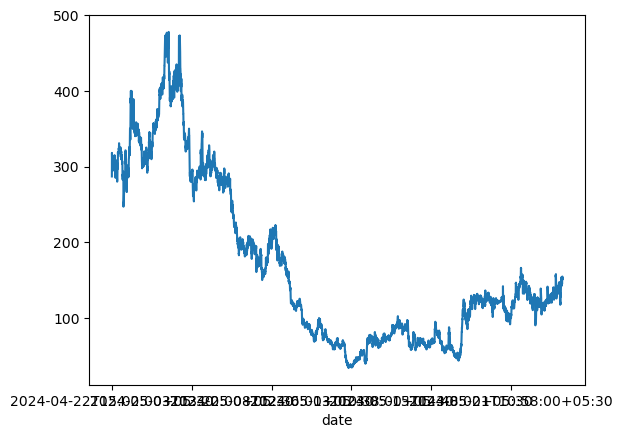

In [27]:
df_data.to_csv("nifty_ce_